In [929]:
import pandas as pd
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

In [930]:
reviews = pd.read_csv("D:/Data Analysis/Reviews/Reviews/reviews_combined.csv")
provider = pd.read_csv("D:/Data Analysis/Reviews/Shop URL list/shop_list_location_details.csv")
print(reviews.head())
print(provider.head())
print(reviews.info())
print(provider.info())

        reviewer_name  rating  \
0         Chad Reagon     5.0   
1  Bernhard Goovaerts     3.0   
2    Bruno De Coninck     5.0   
3    Jochen Vanpoeyer     1.0   
4         Zah beerzel     5.0   

                                         review_text          date  \
0  Good, friendly and fast service. Multi lingual...   5 years ago   
1  Had to wait a little long before being served,...   5 years ago   
2                                        Top service  9 months ago   
3                     If you have half a day time...   5 years ago   
4                                       Top Service!   2 years ago   

                           reviewer_type  \
0                              7 reviews   
1  Local Guide · 210 reviews · 35 photos   
2                               1 review   
3  Local Guide · 24 reviews · 165 photos   
4                               1 review   

                                          source_url  row_number  \
0  https://www.google.com/maps/place/ACS+Telene

In [931]:
reviews_merged = reviews.merge(provider[['shop_name', 'provider','city', 'region','source_url']], on='source_url', how='left')
reviews_merged = reviews_merged.drop(columns=['row_number','batch_number','global_url_number'])
reviews_merged = reviews_merged[reviews_merged['region']!='Hauts-de-France']
print(reviews_merged.info())
print(reviews_merged)

<class 'pandas.core.frame.DataFrame'>
Index: 67071 entries, 0 to 70553
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   reviewer_name     67071 non-null  object 
 1   rating            66249 non-null  float64
 2   review_text       38653 non-null  object 
 3   date              67071 non-null  object 
 4   reviewer_type     63393 non-null  object 
 5   source_url        67071 non-null  object 
 6   expected_reviews  67071 non-null  int64  
 7   shop_name         67071 non-null  object 
 8   provider          67071 non-null  object 
 9   city              67071 non-null  object 
 10  region            67071 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 6.1+ MB
None
            reviewer_name  rating  \
0             Chad Reagon     5.0   
1      Bernhard Goovaerts     3.0   
2        Bruno De Coninck     5.0   
3        Jochen Vanpoeyer     1.0   
4             Zah beerzel     5.0

In [932]:
reviews_merged['reviewer_type'] = reviews_merged['reviewer_type'].fillna('')
def parse_review(text):
    # Local guide flag
    local_guide = 1 if "Local Guide" in text else 0
    
    # Extract reviews
    match_reviews = re.search(r"(\d+)\s+review", text)
    number_reviews = int(match_reviews.group(1)) if match_reviews else 0
    
    # Extract photos
    match_photos = re.search(r"(\d+)\s+photo", text)
    number_photo = int(match_photos.group(1)) if match_photos else 0
    
    return pd.Series([local_guide, number_reviews, number_photo])
reviews_merged[['local_guide', 'number_reviews', 'number_photo']] = reviews_merged['reviewer_type'].apply(parse_review)
print(reviews_merged[['local_guide', 'number_reviews', 'number_photo']].head())

   local_guide  number_reviews  number_photo
0            0               7             0
1            1             210            35
2            0               1             0
3            1              24           165
4            0               1             0


In [933]:
def parse_time_to_year(time_text, current_date=None):
    if current_date is None:
        current_date = datetime.now()
    
    time_text = str(time_text).lower()
    
    # Extract number and time unit
    match = re.search(r'(\d+)?\s*(hour|day|week|month|year)', time_text)
    
    if not match:
        return None
    
    number = int(match.group(1)) if match.group(1) else 1 # default to 1 if no number
    unit = match.group(2)
    
    # Calculate the approximate date
    if unit == 'hour':
        review_date = current_date - timedelta(hours=number)
    elif unit == 'day':
        review_date = current_date - timedelta(days=number)
    elif unit == 'week':
        review_date = current_date - timedelta(weeks=number)
    elif unit == 'month':
        review_date = current_date - timedelta(days=number * 30)  # Approximate
    elif unit == 'year':
        review_date = current_date - timedelta(days=number * 365)
    else:
        return None
    
    return review_date.year

reviews_merged['review_year'] = reviews_merged['date'].apply(parse_time_to_year).astype('Int32')

Reviwews summary over the years:
review_year
2012        2
2013       10
2014       15
2015       18
2016      317
2017     1900
2018     4951
2019    10572
2020     9668
2021    10240
2022     8070
2023     7726
2024     8612
2025     4147
Name: count, dtype: Int64


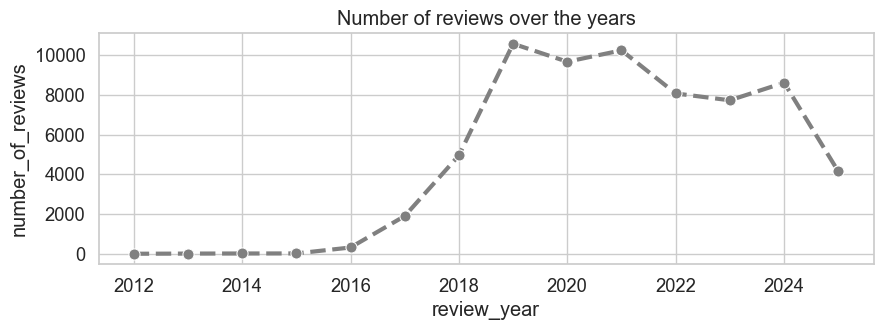

In [934]:
print("Reviwews summary over the years:")
print(reviews_merged['review_year'].value_counts().sort_index())
summary_reviews_number = reviews_merged.groupby('review_year').size().reset_index(name='number_of_reviews')
fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(data=summary_reviews_number, x='review_year', y='number_of_reviews', ax=ax,linewidth=3, linestyle='--', markersize=8,color='gray', marker='o')
ax.set_title('Number of reviews over the years')
plt.show()

In [935]:
print("Profile of reviewers by provider:")
summary_review_profile = reviews_merged.groupby('provider').agg(
    total_reviews=('rating', 'count'),
    average_rating=('rating', 'mean'),
    percentage_local_guides=('local_guide', 'mean'),
)
print(summary_review_profile)


Profile of reviewers by provider:
          total_reviews  average_rating  percentage_local_guides
provider                                                        
BASE               3222        3.738051                 0.590097
Orange            20690        3.650846                 0.605072
Proximus          29766        3.776927                 0.563356
Telenet           12571        3.833824                 0.605834


In [936]:
reviews_merged = reviews_merged[reviews_merged['review_year']>=2016]
reviews_merged = reviews_merged.drop(columns=['reviewer_name', 'date','reviewer_type','source_url'])
print(reviews_merged.info())

<class 'pandas.core.frame.DataFrame'>
Index: 66203 entries, 0 to 70553
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            66203 non-null  float64
 1   review_text       38163 non-null  object 
 2   expected_reviews  66203 non-null  int64  
 3   shop_name         66203 non-null  object 
 4   provider          66203 non-null  object 
 5   city              66203 non-null  object 
 6   region            66203 non-null  object 
 7   local_guide       66203 non-null  int64  
 8   number_reviews    66203 non-null  int64  
 9   number_photo      66203 non-null  int64  
 10  review_year       66203 non-null  Int32  
dtypes: Int32(1), float64(1), int64(4), object(5)
memory usage: 5.9+ MB
None


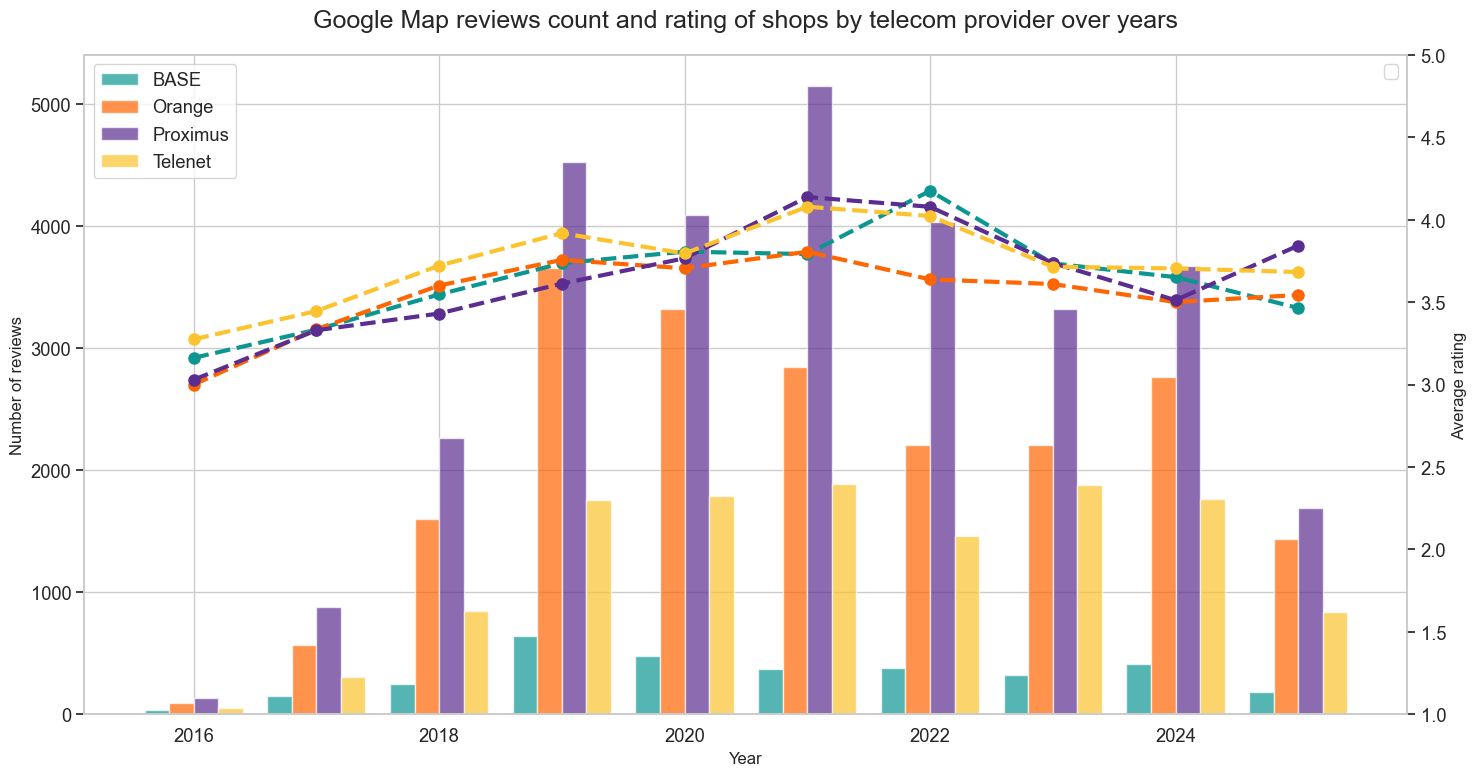

In [946]:
# Create summary data
summary = reviews_merged.groupby(['review_year', 'provider']).agg({
    'rating': ['mean', 'count']
}).reset_index()

# Flatten column names
summary.columns = ['review_year', 'provider', 'avg_rating', 'review_count']

# Define your custom colors
provider_colors = {
    'Orange': '#FF6501',
    'BASE': '#0B9692', 
    'Proximus': '#5B2D90',
    'Telenet': '#FCC32E'
}

# Create one chart with all providers
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()

providers = summary['provider'].unique()
bar_width = 0.8 / len(providers)

for i, provider in enumerate(providers):
    # Filter data for this provider
    provider_data = summary[summary['provider'] == provider].sort_values('review_year')
    
    # Get color for this provider
    color = provider_colors.get(provider, '#808080')  # Default gray if provider not found
    
    # Offset bars for each provider
    x_offset = np.array(provider_data['review_year']) + (i - len(providers)/2 + 0.5) * bar_width
    
    # Bar chart for review count
    ax1.bar(x_offset, provider_data['review_count'], 
            width=bar_width, alpha=0.7, color=color, 
            label=f'{provider}')
    
    # Line chart for average rating (darker version of same color)
    ax2.plot(provider_data['review_year'], provider_data['avg_rating'], 
             color=color, marker='o', linewidth=3, linestyle='--', markersize=8)

# Formatting
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of reviews', fontsize=12)
ax2.set_ylabel('Average rating', fontsize=12)
ax1.set_title('Google Map reviews count and rating of shops by telecom provider over years', 
              fontsize=18, pad=20)
ax2.set_ylim(1, 5)

# Legends
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.grid(True, alpha=0.0)
plt.tight_layout()
plt.show()

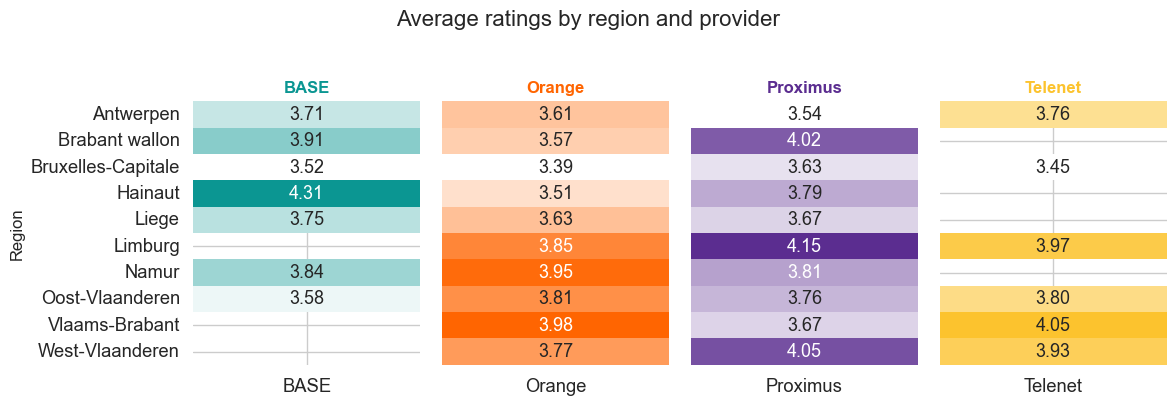

In [948]:
# Create pivot table with providers by region
summary_data = reviews_merged.groupby(['region','provider']).agg({'rating': 'mean', 'review_text': 'count'}).reset_index()
pivot_ratings = summary_data.pivot(index='region', columns='provider', values='rating')

# Create subplots for each provider
fig, axes = plt.subplots(1, len(pivot_ratings.columns), figsize=(12, 4), sharey=True)

for i, provider in enumerate(pivot_ratings.columns):
    # Create single-column data for this provider
    provider_data = pivot_ratings[[provider]]
    
    # Create custom colormap for this provider
    colors = ['white', provider_colors[provider]]
    cmap = LinearSegmentedColormap.from_list(f'{provider}_cmap', colors)
    
    # Create heatmap for this provider
    sns.heatmap(provider_data, 
                annot=True, 
                fmt=".2f", 
                cmap=cmap,
                cbar=False,
                annot_kws={'fontsize':13},
                ax=axes[i])
    axes[i].set_title(provider, color=provider_colors[provider], fontweight='bold', fontsize=12)
    axes[i].set_xlabel('')
    if i == 0:
        axes[i].set_ylabel('Region', fontsize=12)
    else:
        axes[i].set_ylabel('')
    
plt.suptitle('Average ratings by region and provider', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [912]:
reviews_analysis = reviews_merged[reviews_merged['review_text'].isna() == False]
print(reviews_analysis['review_text'].head())

0    Good, friendly and fast service. Multi lingual...
1    Had to wait a little long before being served,...
2                                          Top service
3                       If you have half a day time...
4                                         Top Service!
Name: review_text, dtype: object


# Text analysis

## Preprocessing
### Lowercase; remove URLs, punctuation, and numbers (keep intra-word apostrophes).
### Tokenize; remove stopwords but keep negative one
### Lemmatize verbs and nouns to reduce sparsity.
### Normalize whitespace; drop empty tokens.

## Word clouds
Goal: Visualize prominent terms/phrases per-provider clouds using bigrams (e.g., “customer service”, “network coverage”).

## Sentiment analysis

## Topic modeling
Word cloud only show textual frequeny but not sematic meaning, BERTopic/transformers are optional for richer semantics if needed.

In [913]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt to C:\Users\thaoc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thaoc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\thaoc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\thaoc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\thaoc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [914]:
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Basic cleaning
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Filter and lemmatize in one step
    stop_words = set(stopwords.words('english'))
    common_words = {'store','base','orange','telenet','proximus','shop'}
    union_stop_words = stop_words.union(common_words)
    lemmatizer = WordNetLemmatizer()
    processed_tokens = []
    
    for token in tokens:
        if (token not in union_stop_words and 
            len(token) >= 2 and 
            token.isalpha()):
            pos = get_wordnet_pos(token)
            lemmatized = lemmatizer.lemmatize(token, pos)
            processed_tokens.append(lemmatized)
    
    return ' '.join(processed_tokens)

In [915]:
reviews_analysis['cleaned_text'] = reviews_analysis['review_text'].apply(preprocess_text)
print(reviews_analysis['cleaned_text'].head())

0    good friendly fast service multi lingual big help
1             wait little long serve though service ok
2                                          top service
3                                        half day time
4                                          top service
Name: cleaned_text, dtype: object


In [916]:
review_sentiment = reviews_analysis.copy()
review_sentiment = review_sentiment[review_sentiment['cleaned_text'].isna() == False]

In [917]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

def get_simple_sentiment(text):
    """Get simple positive/negative/neutral sentiment"""
    if pd.isna(text) or text.strip() == '':
        return 'neutral'
    
    # Get VADER compound score
    score = analyzer.polarity_scores(text)['compound']
    
    # Simple 3-category classification
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

review_sentiment['sentiment'] = review_sentiment['cleaned_text'].apply(get_simple_sentiment)
#

In [918]:
# Calculate percentages by provider
provider_sentiment = pd.crosstab(review_sentiment['provider'], 
                                   review_sentiment['sentiment'], 
                                   normalize='index') * 100
print(provider_sentiment.round(1))

sentiment  negative  neutral  positive
provider                              
BASE           19.6     11.1      69.3
Orange         19.0     12.2      68.7
Proximus       17.0     12.5      70.5
Telenet        14.5     11.9      73.6


In [919]:
review_word_cloud = review_sentiment.copy()
review_word_cloud = review_word_cloud[review_word_cloud['cleaned_text'].isna() == False]

In [920]:
def remove_contractions(text):
    # Words/phrases to remove entirely
    to_remove = [
        "dont", "don't", "do not",
        "didnt", "didn't", "did not",
        "doesnt", "doesn't", "does not",
        "cant", "can't", "cannot",
        "wont", "won't", "will not",
        "couldnt", "couldn't", "could not",
        "isnt", "isn't", "is not",
        "wasnt", "wasn't", "was not",
        "arent", "aren't", "are not","even though","although","though", "but","however",
        "mr","mrs","ms","miss","sir","madam",
        "very","really","just","also","always","never",
        "often","sometimes","usually","quite","rather","somewhat",
        "fairly","extremely","absolutely","totally","completely","definitely","certainly","surely","clearly"
    ]
    
    # remove phrases
    for phrase in sorted(to_remove, key=len, reverse=True):
        text = re.sub(r'\b' + re.escape(phrase) + r'\b', '', text, flags=re.IGNORECASE)
    
    # cleanup extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

review_word_cloud['cleaned_text'] = review_word_cloud['cleaned_text'].apply(remove_contractions)


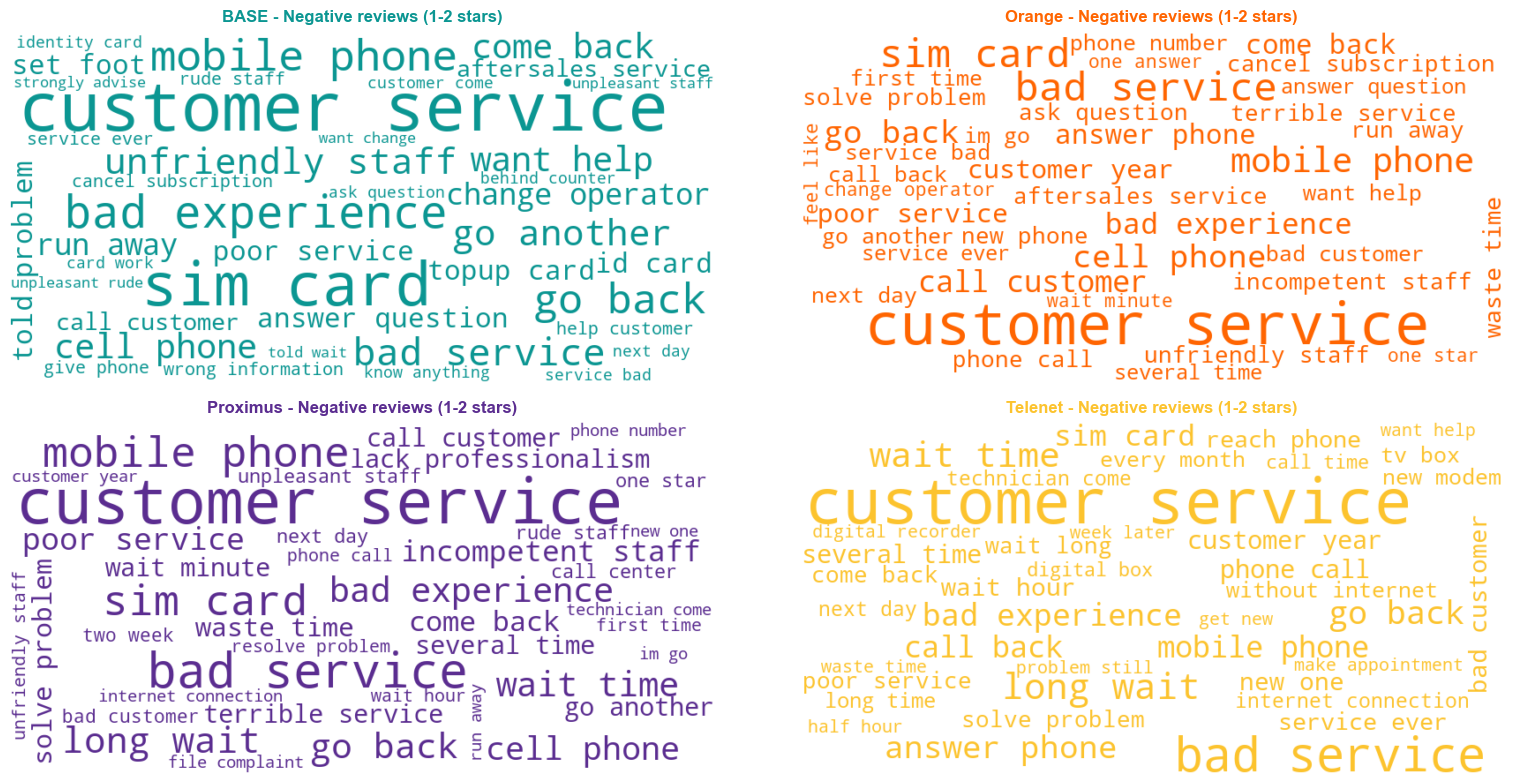

In [921]:
fig, axes = plt.subplots(rows, cols, figsize=(16,8))
axes = axes.flatten()

for i, provider in enumerate(providers):
    # Filter negative reviews for this provider (rating <= 2 and negative sentiment)
    negative_reviews = review_word_cloud[
        (review_word_cloud['provider'] == provider) & 
        (review_word_cloud['sentiment'] == 'negative') &
        (review_word_cloud['rating'] <= 2)
    ]['cleaned_text'].dropna().tolist()
    
    if negative_reviews:
        # Create bigrams
        vec = CountVectorizer(
            ngram_range=(2,2),
            max_features=40,      
            min_df=1               
        )
        X = vec.fit_transform(negative_reviews)
        freqs = dict(zip(vec.get_feature_names_out(), np.asarray(X.sum(axis=0)).ravel()))
        
        # Create custom colormap for this provider
        provider_color = provider_colors.get(provider, '#5B2D90') # Default color
        
        # Create word cloud with provider's brand color
        wc = WordCloud(
            width=800, 
            height=400, 
            background_color="white", 
            random_state=42,
            max_words=50,
            color_func=lambda *args, **kwargs: provider_color 
        )
        wc = wc.generate_from_frequencies(freqs)
        
        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].set_title(f'{provider} - Negative reviews (1-2 stars)', 
                         fontweight='bold', color=provider_color)
    else:
        axes[i].text(0.5, 0.5, f'No negative reviews for {provider}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{provider} - Negative reviews (1-2 stars)', fontweight='bold')
    
    axes[i].axis("off")

# Hide empty subplots if any
for i in range(len(providers), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

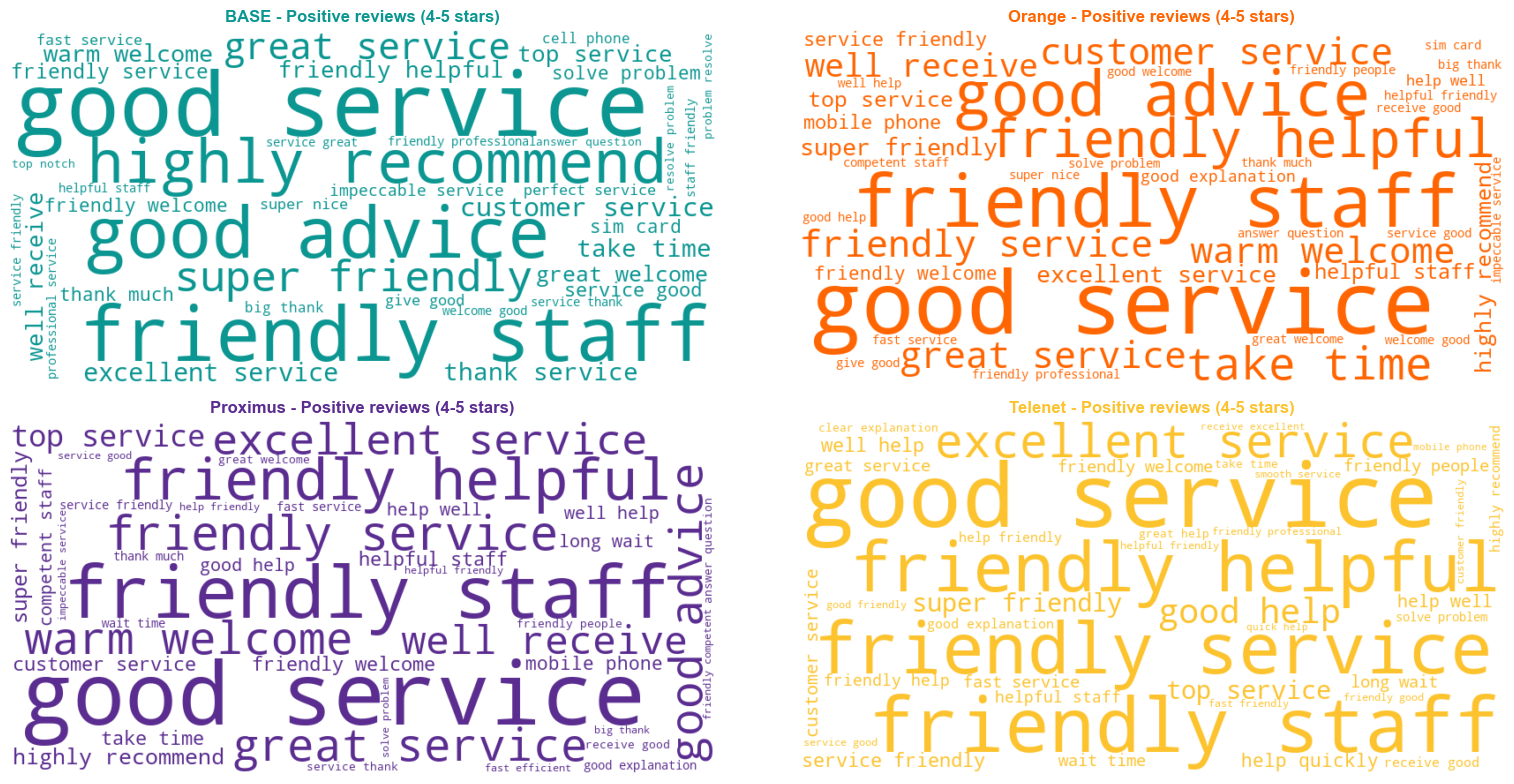

In [922]:
fig, axes = plt.subplots(rows, cols, figsize=(16,8))
axes = axes.flatten()

for i, provider in enumerate(providers):
    # Filter negative reviews for this provider (rating <= 2 and negative sentiment)
    negative_reviews = review_word_cloud[
        (review_word_cloud['provider'] == provider) & 
        (review_word_cloud['sentiment'] == 'positive') &
        (review_word_cloud['rating']>=4)
    ]['cleaned_text'].dropna().tolist()
    
    if negative_reviews:
        # Create bigrams
        vec = CountVectorizer(
            ngram_range=(2,2),
            max_features=40,      
            min_df=1               
        )
        X = vec.fit_transform(negative_reviews)
        freqs = dict(zip(vec.get_feature_names_out(), np.asarray(X.sum(axis=0)).ravel()))
        
        # Create custom colormap for this provider
        provider_color = provider_colors.get(provider, '#5B2D90') # Default color
        
        # Create word cloud with provider's brand color
        wc = WordCloud(
            width=800, 
            height=400, 
            background_color="white", 
            random_state=42,
            max_words=50,
            color_func=lambda *args, **kwargs: provider_color 
        )
        wc = wc.generate_from_frequencies(freqs)
        
        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].set_title(f'{provider} - Positive reviews (4-5 stars)', 
                         fontweight='bold', color=provider_color)
    else:
        axes[i].text(0.5, 0.5, f'No negative reviews for {provider}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{provider} - Positive reviews (4-5 stars)', fontweight='bold')
    
    axes[i].axis("off")

# Hide empty subplots if any
for i in range(len(providers), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()